# Smart Document Retrieval
<p>The primary focus of the notebook is to illustrate the process of using a transformer model to embed text data into a numerical representation that can be used to calculated a similarity score as compared to a query string embedding.</p>

## Imports and Helper Functions

### Imports

In [1]:
## Imports and dependencies
%load_ext autoreload
%autoreload
# Importing the needed libraries & Modules

import glob
import re
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import pickle
from pathlib import Path
import smart_search
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Notebook Variables

In [2]:
DATASET_NAME = "uspto"
EMBEDDING_FOLDER = "../data/embeddings/"
ABSTRACT_PATH = '../data/uspto_abstracts.parquet'

query_strings = [
    "An anomaly detector includes a writing unit that writes anomaly detection data readable by an external diagnostic device to an external memory when an anomaly is detected in an on-board device. Further, the anomaly detector includes a determination unit that determines whether a failure is occurring in a memory, which is used when a processor is operated during the writing unit performs the writing. Also, the anomaly detector includes a resetting unit that resets the memory by activating a specified one of reset functions of the processor when the determination unit determines that a failure is occurring in the memory. When the determination unit determines that a failure is occurring in the memory, the writing unit writes the anomaly detection data after the memory is reset by the specified one of the reset functions.",
    "The anomaly detector writes data to an external memory when an anomaly is detected, checks for memory failures during this process, and if a failure is found, it resets the memory before continuing to write data.",
    ]

### Helper Functions

In [3]:
def load_embeddings(embedding_file_path):
    """
    Load sentences and embeddings from disk.

    Parameters:
    embedding_file_path (str): Path to the file containing embeddings.

    Returns:
    stored_embeddings (list): List of stored embeddings.
    """
    with open(embedding_file_path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_message_id = stored_data['document']
        stored_embeddings = stored_data['embeddings']

    # As of now we only need the stored embeddings
    return stored_embeddings

def write_embeddings(embedding_folder, embedding_file_name, message_ids, source_embeddings):
    """
    Write embeddings and message IDs to disk.

    Parameters:
    embedding_folder (str): Folder where the embedding file will be saved.
    embedding_file_name (str): Name of the file to save the embeddings.
    message_ids (list): List of message IDs.
    source_embeddings (list): List of source embeddings.
    """
    # Check if directory exists
    dir_path = Path(embedding_folder)
    if not dir_path.is_dir():
        print("Directory does not exist. Creating it now.")
        # If the directory doesn't exist, create it
        dir_path.mkdir()
    
    # Create the file path
    file_path = embedding_folder + embedding_file_name
    
    # Write the embeddings and message IDs to disk
    with open(file_path, "wb") as fOut:
        pickle.dump({'document': message_ids, 'embeddings': source_embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

def plot_scores(dataframe):
    """
    Plots the scores from a dataframe.

    Parameters:
    dataframe (pd.DataFrame): DataFrame containing the scores to plot. Must have a column named 'semantic_score'.
    """
    if 'semantic_score' not in dataframe.columns:
        raise ValueError("DataFrame must contain a 'semantic_score' column.")

    plt.figure(figsize=(10, 6))
    plt.plot(dataframe.index, dataframe['semantic_score'], marker='o', linestyle='-')
    plt.xlabel('Index')
    plt.ylabel('Semantic Score')
    plt.title('Semantic Score Plot')
    plt.grid(True)
    plt.show()

def get_or_create_embeddings(dataset_name, model_name, model, df, embedding_folder, load_embeddings, write_embeddings):
    """
    This function checks if embeddings for a given dataset and model combination exist. 
    If they exist, it loads the embeddings. Otherwise, it creates the embeddings and saves them.

    Parameters:
    - dataset_name (str): Name of the dataset.
    - model_name (str): Name of the model.
    - model: The model used to create embeddings.
    - df (DataFrame): The DataFrame containing the data to embed.
    - embedding_folder (str): Path to the folder where embeddings are stored.
    - load_embeddings (function): Function to load embeddings from a file.
    - write_embeddings (function): Function to write embeddings to a file.

    Returns:
    - source_embeddings: The embeddings for the dataset.
    """
    # Create the file name that would be used to store the embeddings.
    embedding_file_name = "embeddings_{}_{}.pkl".format(dataset_name, model_name)

    # Create embedding Path object
    embedding_file = Path(embedding_folder + embedding_file_name)

    # Check if the file exists
    if embedding_file.is_file():
        # If a file exists with the embedding file for this dataset/model combination, load it.
        print("Embedding file exists. Loading it now.")
        source_embeddings = load_embeddings(embedding_file)
    else:
        # If an embedding file does not exist, embed the dataset and cache the data.
        print("Embedding file does not exist. Creating now.")
        source_embeddings = model.encode(df.Abstract, convert_to_tensor=True, show_progress_bar=True)

        # Write out the generated embeddings
        write_embeddings(embedding_folder, embedding_file_name, df.Abstract, source_embeddings)

    print(embedding_file)
    return source_embeddings


def get_topk_results(query_embedding, source_embeddings, df, k=50):
    """
    This function performs a semantic search and returns the top k results with their semantic scores.

    Parameters:
    - query_embedding: The embedding of the query.
    - source_embeddings: The embeddings of the source data.
    - df (DataFrame): The DataFrame containing the data to search.
    - k (int): The number of top results to return.

    Returns:
    - topk_df (DataFrame): A DataFrame containing the top k results and their semantic scores.
    """
    # Using the util function to run semantic search, default to cosine
    topk_results = util.semantic_search(query_embedding, source_embeddings, top_k=k)[0]

    # Extract the result ids and scores
    topk_results_ids = [result['corpus_id'] for result in topk_results]
    topk_scores = [result['score'] for result in topk_results]

    # Get a dataframe of the top k results
    topk_df = df.iloc[topk_results_ids].reset_index()

    # Add the semantic scores to the dataframe
    topk_df['semantic_score'] = topk_scores

    return topk_df

## Example Dataset
<p>The example dataset used in this notebook has been stored in a collection of abstracts extracted from the patent-grant-full-text-dataxml dataset. The abstracts were stored as plain text files, then imported into a dataframe and stored in a parquet file.<p>

In [4]:
# Create the DataFrame
abstract_file = Path(ABSTRACT_PATH)

if abstract_file.is_file():
    df = pd.read_parquet(ABSTRACT_PATH)
    print(f"{df.shape[0]} abstracts loaded.")
else:    
    print('Did not find abstract file.')
    
df.head()    

534169 abstracts loaded.


,Document Number,Date,Title,Abstract
0,11276134,20220315,Reconfigurable image processing hardware pipeline,A reconfigurable image processing pipeline in...
1,11324814,20220510,Live attenuated oral vaccine against ETEC and ...,Disclosed is the attenuated Salmonella typhi ...
2,11508069,20221122,Method for processing event data flow and comp...,The present disclosure provides a method for ...
3,11304408,20220419,Leash attachment,A leash attachment and method for using the l...
4,11383015,20220712,System and method for plasma purification prio...,A method of collecting mononuclear cells incl...


## Source Text Embedding
<p>Historical methods for search involved simple <a href='https://en.wikipedia.org/wiki/Lexicography'>lexicographical</a> similarity pattern matching such as <a href='https://en.wikipedia.org/wiki/Regular_expression'>regex</a>. Although methods such as lexical search can be useful for some use cases, they have several disadvantages such as needing to specific the precise terms to search for. To improve search results it can be advantageous to search based on <a href='https://en.wikipedia.org/wiki/Semantic_similarity#:~:text=Semantic%20similarity%20is%20a%20metric,as%20opposed%20to%20lexicographical%20similarity.'>sematic similarity</a> using concepts rather than word for comparison.</p>

<p>To be able to search by concept we must be able to represent our data in the form of concepts. This is where <a href='https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)'>Transformers</a> come in. <a href='https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)'>Transformers</a> are a form of Machine Learning that can be applied to Natural Language Processing (NLP), the models have been trained on extremely large datasets such as Wikipedia to develop the ability to represent input text as a highly dimensional numerical representation, this process is called <a href='https://vaclavkosar.com/ml/transformer-embeddings-and-tokenization'>embedding</a>. If this sounds complicated, don't worry the hard parts are all abstracted away for us, we just need to use the sentence transformer library. Although there are benefits of understanding how the models work, sometimes it can be just as valuable to show how easy they are to use and how impressive the results can be using off-the-shelf models. If greater accuracy is needed you can always <a href='https://www.sbert.net/docs/training/overview.html'>train transformers</a> on your own datasets to improve their capabilities.</p>

### Model Selection
<p> There are a large number of models to choose from on <a href='https://huggingface.co/'>HuggingFace</a> even for just the task of <a href='https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=downloads'>Sentence Similarity</a>(>800 as of 11/2022). We have included a python module to help simplify organization and selection of a smaller subset of models to experiment with (~100). Using <a href='https://huggingface.co/'>HuggingFace</a> simplifies the process of downloading and running the various models, it is not the only way to consume Transformers but it was chosen as it is one of the easiest ways to get started.</p>
    
There are several areas to consider when selecting a model for a given task
<li><b>Model Size</b> - Large models need more VRAM and can take longer to run but may be more 'accurate'</li>
<li><b>Model Architecture</b> - Some models might be designed for specific use cases or finetuned for a given problem. If your use case is similar, you might have high performance out of the box.</li>
<li><b>Task</b> - Different models have been trained for different tasks. Some examples of various tasks include; Semantic Similarity, Semantic Search, Questioning and Answering, and Document Summarization. 
    
<p>As stated above, the models have been trained to solve a specific workflow. In our case we are trying to identify Semantically Similar documents to our query string. Within the Semantic Similarity group there are subgroups of tasks. These tasks include identifying semantically similar sentences where we try to evaluate two or more sentences and score their similarity. When the elements being evaluated are of similar length (sentence to sentence, paragraph to parapraph) the process is called <b>symmetric semantic search</b>. If you are evaluating a short query phrase or word to sentance, paragraphs, or even documents it is refered to as <b>asymmetric semantic search</b> and models have been specially trained for each type.</p>
    
<li><a href='https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models'>Symmetric Semantic Search Pretrained Models</a></li>
<li><a href='https://www.sbert.net/docs/pretrained-models/msmarco-v3.html'>Asymmetric Semantic Search</a>

### Loading the Model
<p>Loading the model is a simple as passing the model's name as an input argument to create a model object. If the model isn't available locally it will be downloaded automatically. One of the hardest parts of working with HuggingFace is keeping track of all the models available. You can view all the models available for <a href='https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=downloads'>Sentence Similarity</a> and copy the name into the code or to simplify things we have created a very basic python module <a href='smart_search.py'>smart_search.py</a> to hold model names.</p>

<details>
  <summary>SentenceTransformer Parameters</summary>
<li><b>model_name_or_path</b> – If it is a filepath on disc, it loads the model from that path. If it is not a path, it first tries to download a pre-trained SentenceTransformer model. If that fails, tries to construct a model from Huggingface models repository with that name.</li>
<li><b>modules</b> – This parameter can be used to create custom SentenceTransformer models from scratch.</li>
<li><b>device</b> – Device (like ‘cuda’ / ‘cpu’) that should be used for computation. If None, checks if a GPU can be used.</li>
<li><b>cache_folder</b> – Path to store models</li>
<li><b>use_auth_token</b> – HuggingFace authentication token to download private models.</li>
    </details>

In [5]:
# Select and load model.
# Note: If a given model hasn't been used since the container has been loaded it will be downloaded automatically.

# The sentence_models list is a large list of models. They have not been grouped by task beyond sentence similarity 
#model_name = smart_search.sentence_models[3]
#model_name = smart_search_models.default_model

# asymmetric_cosine_similarity_models are special purpose models for Asymmetric Semantic Similarity through cosine similarity calculations
model_name = smart_search.asymmetric_cosine_similarity_models[0]

# symmetric_models are special purpose models for Symmetric Sematic Similarity
#model_name = smart_search.symmetric_models[3]

print("Loading model: '{}'".format(model_name))
#model = SentenceTransformer(model_name,cache_folder='./models/', device='cpu')
model = SentenceTransformer(model_name,cache_folder='../models/', device='cuda')

Loading model: 'msmarco-distilbert-base-v4'


/home/workbench/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Source Text Embedding
<p>To embed the source text, we can pass the entire column of our dataset into the model object in a single line of code as shown in the cell blocks below.</p>

<p>A couple important items to note here:
    <li>You only need to embed the source text once for a given model. Depending on your use case you may wish to database the embeddings for later use, just remember to keep track of the model used for embedding and the source document.</li>
    <li>As each model will embed the input text differently you need to ensure the source text and query text were embedded using the same model. If you choose to database or store your embedding for later just be sure to track which models were used for the embedding as you will likely get unexpected results if comparing embedding from different models.</li>
    </p>


<details>
  <summary>encode Parameters</summary>
    <li><b>sentences</b> – the sentences to embed</li>
    <li><b>batch_size</b> – the batch size used for the computation</li>
    <li><b>show_progress_bar</b> – Output a progress bar when encode sentences</li>
    <li><b>output_value</b> – Default sentence_embedding, to get sentence embeddings. Can be set to token_embeddings to get wordpiece token embeddings. Set to None, to get all output values</li>
    <li><b>convert_to_numpy</b> – If true, the output is a list of numpy vectors. Else, it is a list of pytorch tensors.</li>
    <li><b>convert_to_tensor</b> – If true, you get one large tensor as return. Overwrites any setting from convert_to_numpy</li>
    <li><b>device</b> – Which torch.device to use for the computation</li>
    <li><b>normalize_embeddings</b> – If set to true, returned vectors will have length 1. In that case, the faster dot-product (util.dot_score) instead of cosine similarity can be used.</li>
</details>

### Embedding the entire dataset
We only need to embed the entire dataset once. We can check if the model / dataset embeddings already exist. If so just load them from disk. If not, process them. This can take as long as 30 minutes to embed the ~500,000 patents.

The timings are a result of test runs using an NVIDIA RTX A3500 on a Dell Precision 5680 Laptop.

<details>
  <summary>Benchmark Timing</summary>
    <b>Model</b> – msmarco-distilbert-base-v4
    <li><b>Abstracts</b> – 534,169</li>
    <li><b>Wall Time</b> – 12min 26s</li>
</details>

In [6]:
%%time
source_embeddings = get_or_create_embeddings(DATASET_NAME, model_name, model, df, EMBEDDING_FOLDER, load_embeddings, write_embeddings)

Embedding file does not exist. Creating now.


Batches: 100%|██████████| 16693/16693 [12:15<00:00, 22.71it/s] 


Directory does not exist. Creating it now.
../data/embeddings/embeddings_uspto_msmarco-distilbert-base-v4.pkl
CPU times: user 19min 21s, sys: 4min 7s, total: 23min 29s
Wall time: 12min 26s


## 6) Query String Embedding
<p>Using the same model, we then embed our query string to be used for comparison.</p>

In [7]:
%%time
# Embed the query string
#query_string = 'Artificial intelligence (AI) anomaly monitoring in a storage system. The AI anomaly monitoring may include writing commands into a log jointly with the execution of the commands on storage media of a drive. The log includes information regarding the operation of the drive including, at least, the commands. In turn, each drive in the storage system may include an AI processor core that may access the log and apply an AI analysis to the log to monitor for an anomaly regarding the operation of the drive. As each drive in the storage system may use the AI process core to detect anomalies locally to the drive, the computational and network resources needed to employ the AI monitoring may be reduced.'
query_string = [query_strings[1]]
query_embedding = model.encode(query_string,convert_to_tensor=True)

print(query_string)

['The anomaly detector writes data to an external memory when an anomaly is detected, checks for memory failures during this process, and if a failure is found, it resets the memory before continuing to write data.']
CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 29.8 ms


## 7) Similarity Scoring and Ranking
<p>Next, we need to calculate the similarity between the query embedding and all the source text embeddings. One of the most common approaches is to calculate the cosine similarity. Again, the complexities and math have been abstracted here with the <a href='https://www.sbert.net/docs/package_reference/util.html'>util.cos_sim</a> and sematic_search functions.</p>

In [8]:
%%time
topk_df = get_topk_results(query_embedding, source_embeddings, df, k=50)

CPU times: user 70.5 ms, sys: 9.15 ms, total: 79.7 ms
Wall time: 97.8 ms


In [9]:
topk_df.head()

,index,Document Number,Date,Title,Abstract,semantic_score
0,371003,11379310,20220705,Anomaly detector,An anomaly detector includes a writing unit t...,0.880796
1,405805,11423698,20220823,Anomaly detector for detecting anomaly using c...,Embodiments of the present disclosure disclos...,0.723084
2,121415,11689434,20230627,Network anomaly detection,An anomaly detector of a Controller Area Netw...,0.696264
3,312248,11425005,20220823,Controller area network anomaly detection,An anomaly detector of a Controller Area Netw...,0.696240
4,254448,11293989,20220405,"Anomaly detection device, anomaly detection me...",An anomaly detection device includes: at leas...,0.684741


In [10]:
for i in range(5):
    print(f"Document: {topk_df['Document Number'][i]}")
    print(f"Title: {topk_df['Title'][i]}")
    print(f"Semantic Score: {topk_df['semantic_score'][i]}")
    print(f"Abstract: {topk_df['Abstract'][i]}\n")
    

Document: 11379310
Title: Anomaly detector
Semantic Score: 0.8807964324951172
Abstract:  An anomaly detector includes a writing unit that writes anomaly detection data readable by an external diagnostic device to an external memory when an anomaly is detected in an on-board device. Further, the anomaly detector includes a determination unit that determines whether a failure is occurring in a memory, which is used when a processor is operated during the writing unit performs the writing. Also, the anomaly detector includes a resetting unit that resets the memory by activating a specified one of reset functions of the processor when the determination unit determines that a failure is occurring in the memory. When the determination unit determines that a failure is occurring in the memory, the writing unit writes the anomaly detection data after the memory is reset by the specified one of the reset functions. 

Document: 11423698
Title: Anomaly detector for detecting anomaly using complem

## Visualizing the Semantic Scores

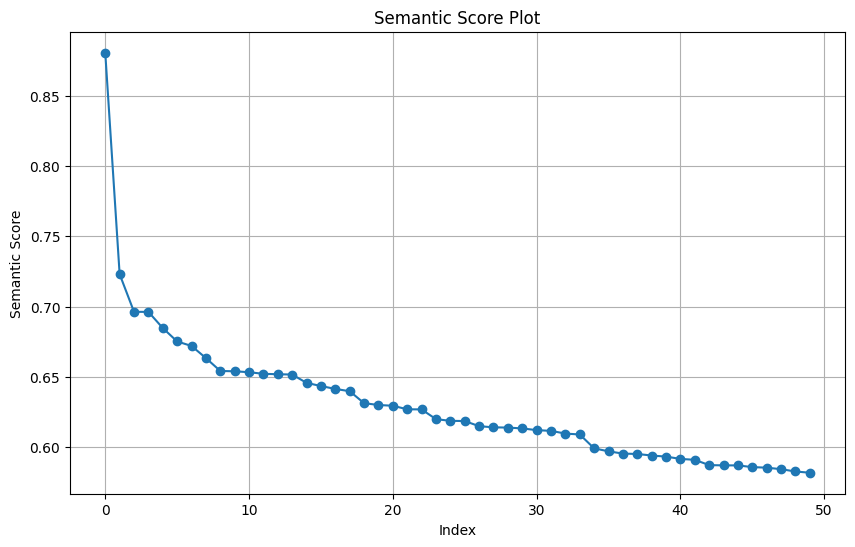

In [11]:
plot_scores(topk_df)